In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import kagglehub


In [7]:
dataset_path = kagglehub.dataset_download(
    "kmader/skin-cancer-mnist-ham10000"
)

print("Dataset path:", dataset_path)


Using Colab cache for faster access to the 'skin-cancer-mnist-ham10000' dataset.
Dataset path: /kaggle/input/skin-cancer-mnist-ham10000


In [9]:
metadata_path = os.path.join(dataset_path, "HAM10000_metadata.csv")
df = pd.read_csv(metadata_path)

# Cancer labels
cancer_classes = {"mel", "bcc", "akiec"}

df["target"] = df["dx"].isin(cancer_classes).astype(int)

df[["dx", "target"]].head()

,dx,target
0,bkl,0
1,bkl,0
2,bkl,0
3,bkl,0
4,bkl,0


In [10]:
image_dirs = [
    os.path.join(dataset_path, "HAM10000_images_part_1"),
    os.path.join(dataset_path, "HAM10000_images_part_2"),
]

def find_image_path(image_id):
    for d in image_dirs:
        path = os.path.join(d, image_id + ".jpg")
        if os.path.exists(path):
            return path
    return None

df["image_path"] = df["image_id"].apply(find_image_path)
df = df.dropna(subset=["image_path"])

In [11]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["target"],
    random_state=42
)

print(train_df["target"].value_counts())
print(val_df["target"].value_counts())


target
0    6449
1    1563
Name: count, dtype: int64
target
0    1612
1     391
Name: count, dtype: int64


In [12]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col="image_path",
    y_col="target",
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="raw",
    batch_size=BATCH_SIZE
)

val_data = val_gen.flow_from_dataframe(
    val_df,
    x_col="image_path",
    y_col="target",
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="raw",
    batch_size=BATCH_SIZE
)


Found 8012 validated image filenames.
Found 2003 validated image filenames.


In [13]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=train_df["target"]
)

class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.6211815785393084), 1: np.float64(2.563019833653231)}


In [14]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False  # freeze pretrained layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.Precision(name="precision")
    ]
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    class_weight=class_weights
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - accuracy: 0.7063 - loss: 0.5813 - precision: 0.3617 - recall: 0.7026 - val_accuracy: 0.7309 - val_loss: 0.5276 - val_precision: 0.4089 - val_recall: 0.8491
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 338s 1s/step - accuracy: 0.7703 - loss: 0.4590 - precision: 0.4570 - recall: 0.8221 - val_accuracy: 0.7234 - val_loss: 0.5398 - val_precision: 0.4047 - val_recall: 0.8849
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step - accuracy: 0.7614 - loss: 0.4457 - precision: 0.4481 - recall: 0.8181 - val_accuracy: 0.7449 - val_loss: 0.5280 - val_precision: 0.4259 - val_recall: 0.8824
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 366s 1s/step - accuracy: 0.7776 - loss: 0.4154 - precision: 0.4584 - recall: 0.8272 - val_accuracy: 0.6875 - val_loss: 0.6386 - val_precision: 0.3775 - val_recall: 0.9258
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.7812 - loss: 0.4114 - precision: 0.4709 - recall: 0.8494 - val_accuracy: 0.7299 - val_los

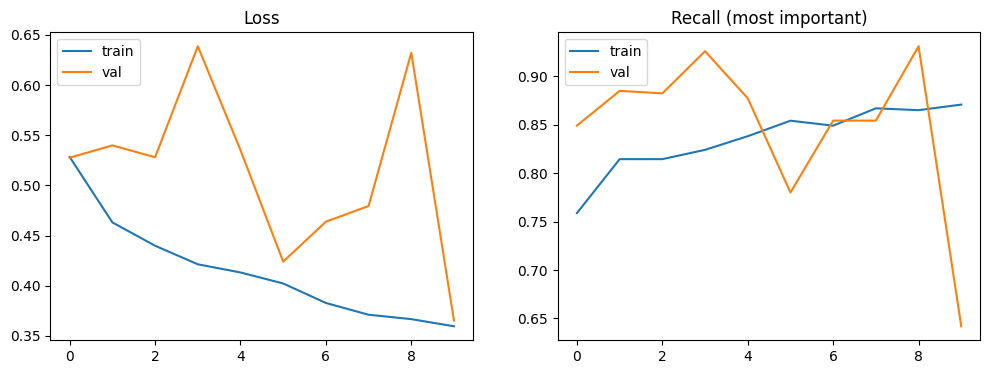

In [16]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["recall"], label="train")
plt.plot(history.history["val_recall"], label="val")
plt.title("Recall (most important)")
plt.legend()

plt.show()


In [17]:
def predict_image(img_path):
    img = tf.keras.preprocessing.image.load_img(
        img_path, target_size=(IMG_SIZE, IMG_SIZE)
    )
    img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    prob = model.predict(img)[0][0]
    return prob, "Cancer" if prob > 0.5 else "Non-Cancer"


In [ ]:
from tensorflow.keras.preprocessing import image

IMG_SIZE = 224  # same as training

def predict_image(img_path, model):
    """
    Predicts whether the input image is cancer or non-cancer.
    
    Args:
        img_path (str): Path to the image
        model (tf.keras.Model): Trained model

    Returns:
        prob (float): Probability of cancer
        label (str): 'Cancer' or 'Non-Cancer'
    """
    # Load image and resize
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    # Convert to array
    img_array = image.img_to_array(img)
    # Scale pixels 0-1
    img_array = img_array / 255.0
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    # Predict probability
    prob = model.predict(img_array)[0][0]
    label = "Cancer" if prob > 0.5 else "Non-Cancer"

    return prob, label
